In [1]:
from dl_modulator import LitTrainerFactory, Config, LitSqrtFilterModule, SqrtFilterDataModule, SqrtFilterParams

In [2]:
# config = Config.read("R001-Apr22")
config = Config()
hparams  = SqrtFilterParams(num_samples=1000)

In [3]:
datamodule = SqrtFilterDataModule(config, hparams)

In [4]:
datamodule.prepare_data()

/home/duchsche/repos/pypho-ws/pypho/pypho/pypho_setup.py:160: UserWarning: Center frequency f0 not specified, so I am using 193414489032258.06 Hz
  warn(f"Center frequency f0 not specified, so I am using {self.f0} Hz")
/home/duchsche/repos/pypho-ws/pypho/pypho/pypho_setup.py:175: UserWarning: Cloud not specified, so I am using False
  warn("Cloud not specified, so I am using False")


Found wisdom!
Checking / creating wisdom to speed up FFTW...
Checking / creating wisdom to speed up FFTW...


100%|██████████| 1000/1000 [00:01<00:00, 605.31it/s]


In [5]:
datamodule.setup("fit")

In [6]:
data_loader = datamodule.train_dataloader()
pass

In [ ]:
next(iter(data_loader))[0].shape

In [2]:
import torch
import numpy as np

def raised_cosine_filter_torch(alpha, B, Df, nos, sps, symbolrate):
    T1 = 1.0 / (B * 1.0e9)
    n_samples = nos * sps
    offset = -Df * 1.0e9 - (sps * nos / 2.0) * (symbolrate / nos)

    # Creating the filter in the frequency domain
    filfunc = torch.zeros(n_samples)
    res = symbolrate / nos
    z_values = torch.arange(n_samples)
    freqs = z_values * res + offset

    # Mask for different regions
    mask1 = torch.abs(freqs) <= ((1 - alpha) * B / 2 * 1.0e9)
    mask2 = (torch.abs(freqs) > ((1 - alpha) * B / 2 * 1.0e9)) & (torch.abs(freqs) <= (1 + alpha) * B / 2 * 1.0e9)

    filfunc[mask1] = 1.0
    filfunc[mask2] = 0.5 * (1 + torch.cos(torch.pi / (alpha * B / 2 * 1.0e9) * (torch.abs(freqs[mask2]) - (1 - alpha) * B / 2 * 1.0e9)))

    # Apply windowing to taper the edges of the filter
    window = torch.hann_window(n_samples, periodic=False)
    filfunc *= window

    return filfunc

def apply_filter_in_freq_domain(signal, filter_func):
    # Forward FFT
    fft_signal = torch.fft.fft(signal)

    # Apply filter
    filtered_fft_signal = fft_signal * filter_func

    # Inverse FFT
    filtered_signal = torch.fft.ifft(filtered_fft_signal)

    return filtered_signal.real  # Assuming the original signal is real

# Example usage
nos = 100
sps = 10
symbolrate = 1.0e9
alpha = 0.35
B = 0.025  # Bandwidth in GHz
Df = 0  # Frequency offset in GHz
n_samples = nos * sps

# Generate a random signal
signal = torch.rand(n_samples)

# Compute filter coefficients
filter_coefficients = raised_cosine_filter_torch(alpha, B, Df, nos, sps, symbolrate)

# Apply the filter
filtered_signal = apply_filter_in_freq_domain(signal, filter_coefficients)

print(filtered_signal)


tensor([ 0.0169, -0.0169,  0.0169, -0.0169,  0.0170, -0.0170,  0.0170, -0.0170,
         0.0170, -0.0170,  0.0171, -0.0171,  0.0171, -0.0171,  0.0171, -0.0172,
         0.0172, -0.0172,  0.0172, -0.0172,  0.0172, -0.0172,  0.0173, -0.0173,
         0.0173, -0.0173,  0.0173, -0.0173,  0.0174, -0.0174,  0.0174, -0.0174,
         0.0174, -0.0174,  0.0174, -0.0175,  0.0175, -0.0175,  0.0175, -0.0175,
         0.0175, -0.0175,  0.0175, -0.0176,  0.0176, -0.0176,  0.0176, -0.0176,
         0.0176, -0.0176,  0.0176, -0.0176,  0.0177, -0.0177,  0.0177, -0.0177,
         0.0177, -0.0177,  0.0177, -0.0177,  0.0177, -0.0177,  0.0177, -0.0178,
         0.0178, -0.0178,  0.0178, -0.0178,  0.0178, -0.0178,  0.0178, -0.0178,
         0.0178, -0.0178,  0.0178, -0.0178,  0.0178, -0.0178,  0.0178, -0.0179,
         0.0179, -0.0179,  0.0179, -0.0179,  0.0179, -0.0179,  0.0179, -0.0179,
         0.0179, -0.0179,  0.0179, -0.0179,  0.0179, -0.0179,  0.0179, -0.0179,
         0.0179, -0.0179,  0.0179, -0.01

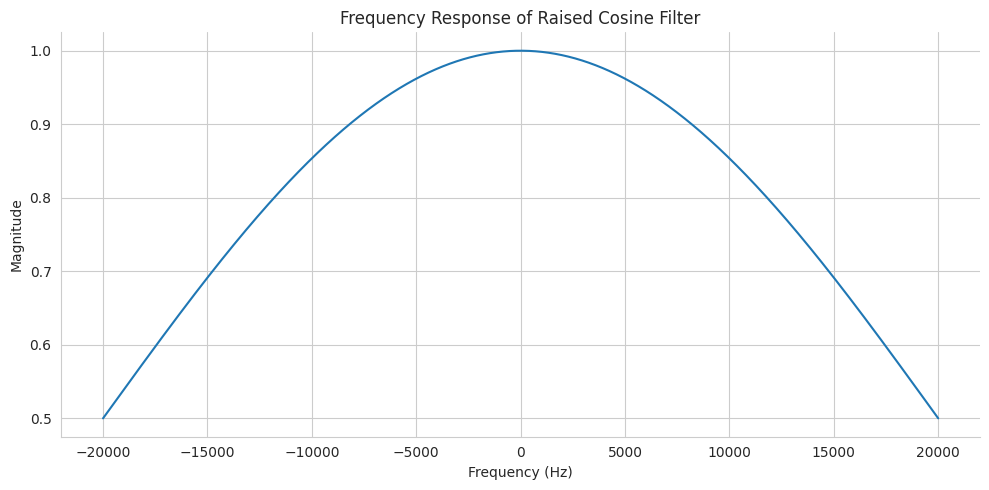

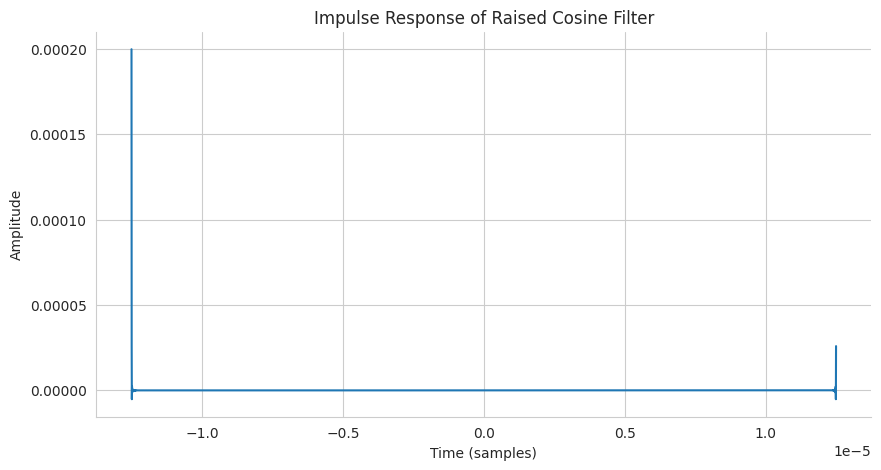

In [29]:
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from pydantic import BaseModel, Field, field_validator, model_validator


class RaisedCosineParameters(BaseModel):
    fc: float = Field(..., description="Center frequency in Hz")
    B: float = Field(..., description="Bandwidth in Hz", gt=0)
    alpha: float = Field(
        ..., description="Roll-off factor, 0 <= alpha <= 1", ge=0, le=1
    )
    fs: float = Field(..., description="Sampling frequency in Hz")
    nos: int = Field(128, description="Number of symbols")
    sps: int = Field(32, description="Samples per symbol")
    N: int = Field(init=False, description="Number of samples")
    attenuation_db: float = Field(0, description="Attenuation in dBm")

    @model_validator(mode="after")
    def __set_N(self) -> "RaisedCosineParameters":
        self.N = self.nos * self.sps

        assert (self.N ) & (self.N - 1) == 0, "N must be a power of 2"

        return self

class RaisedCosineFilter:
    def __init__(self, params: RaisedCosineParameters):
        self.params = params
        self.frequency_response = self.calculate_frequency_response()
        self.impulse_response = self.calculate_impulse_response()

    def calculate_frequency_response(self) -> torch.Tensor:
        """_summary_

        Returns:
            torch.Tensor: _description_
        """
        f = torch.linspace(
            -self.params.fs / 2, self.params.fs / 2, self.params.N, dtype=torch.float64
        )

        freq_response = torch.zeros_like(f)

        f_shifted = torch.abs(f - self.params.fc)

        # Define the response based on conditions
        # Passband
        cond1 = f_shifted <= self.params.fs * (1 - self.params.alpha) / 2
        freq_response[cond1] = 1

        # Transition band
        cond2 = (f_shifted > self.params.fs * (1 - self.params.alpha) / 2) & (
            f_shifted <= self.params.fs * (1 + self.params.alpha) / 2
        )
        freq_response[cond2] = 0.5 * (
            1
            + torch.cos(
                np.pi
                / (self.params.fs * self.params.alpha)
                * (f_shifted[cond2] - self.params.fs * (1 - self.params.alpha) / 2)
            )
        )

        return freq_response * 10 ** (-self.params.attenuation_db / 10)

    def calculate_impulse_response(self):
        # Shift the zero-frequency component to the start of the array
        freq_response_shifted = torch.fft.ifftshift(self.frequency_response)

        # Calculate the impulse response by IFFT of the frequency response
        h = torch.fft.ifft(freq_response_shifted)
        h_centered = h / len(self.frequency_response)
        return h_centered

    def plot_frequency_response(self, input_signal: Optional[torch.Tensor] = None, filtered_signal: Optional[torch.Tensor] = None):
        f = np.linspace(-self.params.fs / 2, self.params.fs / 2, self.params.N)

        if input_signal is not None and filtered_signal is not None:
            input_signal_fft = torch.fft.fftshift(torch.fft.fft(input_signal))
            filtered_signal_fft = torch.fft.fftshift(torch.fft.fft(filtered_signal))
            magnitude_input = np.abs(input_signal_fft.numpy())
            magnitude_filtered = np.abs(filtered_signal_fft.numpy())
            title = 'Frequency Response of Input and Filtered Signals'
        else:
            magnitude = torch.abs(self.frequency_response).numpy()
            title = 'Frequency Response of Raised Cosine Filter'

        plt.figure(figsize=(10, 5))
        sns.set_style("whitegrid")

        if input_signal is not None and filtered_signal is not None:
            sns.lineplot(x=f, y=magnitude_input, label='Input Signal')
            sns.lineplot(x=f, y=magnitude_filtered, label='Filtered Signal')
        else:
            sns.lineplot(x=f, y=magnitude)

        plt.title(title)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")

        sns.despine()
        plt.tight_layout()
        plt.show()

    def plot_impulse_response(self, input_signal: Optional[torch.Tensor] = None, filtered_signal: Optional[torch.Tensor] = None, x_lim: Optional[float] = None):
        # t = np.arange(-self.params.N // 2, self.params.N // 2)
        t = np.linspace(1 / (-2 * self.params.fs), 1/(2 * self.params.fs), self.params.N)

        if input_signal is not None and filtered_signal is not None:
            input_signal_np = input_signal.numpy().real
            filtered_signal_np = filtered_signal.numpy().real
            title = 'Time Response of Input and Filtered Signals'
        else:
            impulse = self.impulse_response.numpy().real
            title = 'Impulse Response of Raised Cosine Filter'

        plt.figure(figsize=(10, 5))
        sns.set_style("whitegrid")

        if input_signal is not None and filtered_signal is not None:
            sns.lineplot(x=t, y=input_signal_np, label='Input Signal')
            sns.lineplot(x=t, y=filtered_signal_np, label='Filtered Signal')
        else:
            sns.lineplot(x=t, y=impulse)

        plt.title(title)
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")

        if x_lim:
            plt.xlim(-x_lim, x_lim)

        sns.despine()
        plt.show()

    def apply(self, signal: torch.Tensor) -> torch.Tensor:
        """Applies the filter in the frequency domain

        Args:
            signal (torch.Tensor): An input signal of shape (N,) or (N, 2)

        Returns:
            torch.Tensor: The filtered signal
        """
        signal_fft = torch.fft.fft(signal)
        filtered_signal_fft = signal_fft * self.frequency_response
        filtered_signal = torch.fft.ifft(filtered_signal_fft) / self.params.N
        return filtered_signal


params = RaisedCosineParameters(fc=0, B=10e3, alpha=1, fs=40e3, N=4096)
filter = RaisedCosineFilter(params)
filter.plot_frequency_response()
filter.plot_impulse_response()


In [33]:

# Calculate pulse width
pulse_width = params.sps / 5e3

# Generate a single pulse
single_pulse = torch.cat((torch.ones(int(pulse_width)), torch.zeros(int(params.N - pulse_width))))

# Generate a signal that is a pulse repeating randomly params.nos times
repeats = torch.randint(low=1, high=params.sps+1, size=(params.sps *params.nos))  # random number of repeats for each pulse
signal = torch.repeat_interleave(single_pulse, repeats)

# Truncate or zero-pad the signal to match the desired length
if len(signal) > params.N:
    signal = signal[:params.N]  # truncate
else:
    signal = torch.cat((signal, torch.zeros(params.N - len(signal))))  # zero-pad

# Now you can use this signal in your code
filtered_signal = filter.apply(signal)
filter.plot_frequency_response(input_signal=signal, filtered_signal=filtered_signal)
filter.plot_impulse_response(input_signal=signal, filtered_signal=filtered_signal, x_lim=20)

TypeError: randint() received an invalid combination of arguments - got (size=int, high=int, low=int, ), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [12]:
10 ** (0 / 20)

1.0